In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

import logging


In [4]:
import qt3utils.experiments.podmr
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

In [5]:
pulser = qcsapphire.Pulser('COM4')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [23]:
rfsynth.rf_off(0)

In [6]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [7]:
def aggregate_mean_data(data_buffer, experiment):
    '''
    Calls qt3utils.analysis.aggregation.reshape_sum_trace, where
        cwodmr.N_cycles = N_rows
        cwodmr.N_clock_ticks_per_cycle = N_samples_per_row

    '''
    return qt3utils.analysis.aggregation.reshape_mean_trace(data_buffer,
                                                           experiment.N_cycles,
                                                           experiment.N_clock_ticks_per_cycle)

In [8]:
logging.basicConfig(level=logging.WARNING)

In [9]:
qt3utils.experiments.podmr.logger.setLevel(logging.WARNING)

In [10]:
def recombine_scans(set_of_scans):
    combined_scans = {s[0]:np.zeros(s[-1].shape[0]) for s in set_of_scans[0]}

    for scan in set_of_scans:
        for read in scan:
            width = read[0]
            data = read[-1]
            combined_scans[width] += data

    reconstructed_scan = [[s, len(combined_scans[s]), combined_scans[s]] for s in sorted(list(combined_scans.keys()))]
    return reconstructed_scan

In [11]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

In [12]:
def signal_to_background(trace, pre_trigger, aom_width, rf_width, post_rf_pad, verbose=False,
                        signal_aom_width_duty = 1.0, background_aom_width_duty = 1.0,
                        aggregation = np.sum):
    '''
    Assumes trace produced by qt3utils.experiments.rabi.Rabi class and
    is the aggregated data for a particular RF width.

    The inputs `pre_trigger`, `aom_width` and `rf_width` are all in units of index of the trace.
    That is, they are in units of clock ticks.

    Assumes that trace is of shape
        * pre_trigger
        * aom_width: aom on / rf off (background)
        * rf_width:  aom off / rf on
        * aom_width: aom on/ rf off  (signal)

    returns sum(signal) / sum(background)

    '''
    background_end = pre_trigger + int(aom_width*background_aom_width_duty)
    signal_start = pre_trigger + aom_width + rf_width + post_rf_pad
    signal_end = signal_start + int(aom_width*signal_aom_width_duty)

    background = aggregation(trace[pre_trigger:background_end])
    signal = aggregation(trace[signal_start:signal_end])

    if verbose:
        print(f'inputs. pre_trigger = {pre_trigger}, aom_width = {aom_width}, rf_width = {rf_width}')
        print(f'        signal_duty = {signal_aom_width_duty}, bkgd_duty = {background_aom_width_duty}')
        print(f'        aggregation = {aggregation}')
        print(f'background: {pre_trigger} -> {background_end}')
        print(trace[pre_trigger:background_end])
        print(f'signal: {signal_start} -> {signal_end}')
        print(trace[signal_start:signal_end])

    return signal / background



In [13]:
def build_contrast(single_scan, clock_period, aom_width_time, rf_width_time, post_rf_pad, 
                   pre_trigger = 2, signal_duty=0.25, background_duty=0.25, verbose = False):

    contrast = []
    if verbose:
        print(clock_period)
        print(aom_width_time)
        print(post_rf_pad)
    for measurement in single_scan:
        
        rf_frequency = measurement[0]
        #N_samples_per_cycle = measurement[1]
        #clock_period = rabi.clock_period
        #aom_width_time = rabi.aom_width
        summed_trace = measurement[2]
 
        aom_width_ticks = int(aom_width_time / clock_period)
        rf_width_ticks = int(rf_width_time / clock_period)
        # post_rf_pad_ticks = np.round(rabi.post_rf_pad / clock_period).astype(int)
        post_rf_pad_ticks = int(post_rf_pad / clock_period)

        c = signal_to_background(summed_trace, 
                                 pre_trigger, 
                                 aom_width_ticks, 
                                 rf_width_ticks, 
                                 post_rf_pad_ticks,
                                 signal_aom_width_duty = signal_duty, 
                                 background_aom_width_duty = background_duty , aggregation = np.mean, verbose=verbose)

        contrast.append([rf_frequency, c]) 

    contrast = np.array(contrast)
    return contrast

In [14]:
experiment = qt3utils.experiments.podmr.PulsedODMR(pulser, rfsynth, nidaq_config, rf_width = 1e-6, rf_power = -20)

In [15]:
experiment.rfsynth.rf_on(experiment.rfsynth_channel)
time.sleep(2)
print(experiment.experimental_conditions())

full_scans = []

for i in range(50):
    if i % 5 == 0:
        print(i)
    scan_data = experiment.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(i%2==0))
    full_scans.append(scan_data)
    
    #scan_data = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data)

{'freq_low': 2820000000.0, 'freq_high': 2920000000.0, 'freq_step': 1000000.0, 'rf_power': -20, 'rf_width': 1e-06, 'aom_width': 3e-06, 'aom_response_time': 8e-07, 'post_rf_pad': 1e-06, 'pre_rf_pad': 2e-07, 'clock_period': 2e-07}
0
5
10
15
20
25
30
35
40
45


In [16]:
reconstructed_single_scan = recombine_scans(full_scans)

In [17]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

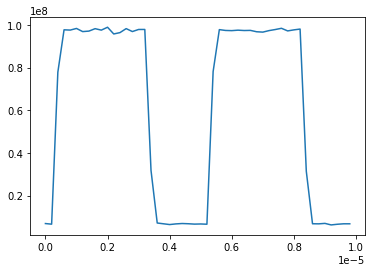

In [18]:
scan = reconstructed_single_scan[10]
plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

In [19]:
pre_trigger = 2
aom_width = int(experiment.aom_width / experiment.clock_period)
#rf_delay = int((experiment.aom_response_time  + experiment.pre_rf_pad)/experiment.clock_period)
rf_width = int(experiment.rf_width / experiment.clock_period)
post_rf_pad = int(experiment.post_rf_pad / experiment.clock_period)

print(aom_width)
#print(rf_delay)
print(rf_width)
print(post_rf_pad)
print(scan[-1])
print('function')

signal_to_background(scan[-1], pre_trigger, aom_width, rf_width, post_rf_pad, verbose=True)

15
5
5
[ 1.368  1.311 15.569 19.548 19.523 19.676 19.381 19.427 19.655 19.519
 19.789 19.158 19.285 19.66  19.385 19.58  19.581  6.354  1.419  1.346
  1.274  1.335  1.371  1.35   1.315  1.329  1.305 15.632 19.565 19.488
 19.471 19.514 19.482 19.494 19.366 19.332 19.474 19.574 19.69  19.445
 19.542 19.618  6.274  1.349  1.341  1.383  1.24   1.302  1.345  1.345]
function
inputs. pre_trigger = 2, aom_width = 15, rf_width = 5
        signal_duty = 1.0, bkgd_duty = 1.0
        aggregation = <function sum at 0x000001F6BB72C700>
background: 2 -> 17
[15.569 19.548 19.523 19.676 19.381 19.427 19.655 19.519 19.789 19.158
 19.285 19.66  19.385 19.58  19.581]
signal: 27 -> 42
[15.632 19.565 19.488 19.471 19.514 19.482 19.494 19.366 19.332 19.474
 19.574 19.69  19.445 19.542 19.618]


0.9998302948021721

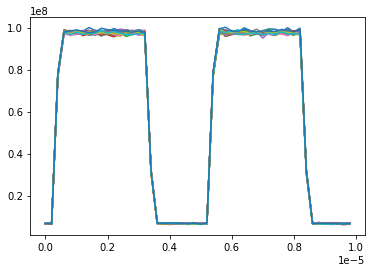

In [20]:
for scan in reconstructed_single_scan[::5]:
    plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

In [21]:
contrast = build_contrast(reconstructed_single_scan, experiment.clock_period, 
                          experiment.aom_width, experiment.rf_width,
                          experiment.post_rf_pad, signal_duty=.5, background_duty=.5)
x_data = contrast[:, 0]
y_data = contrast[:, 1]

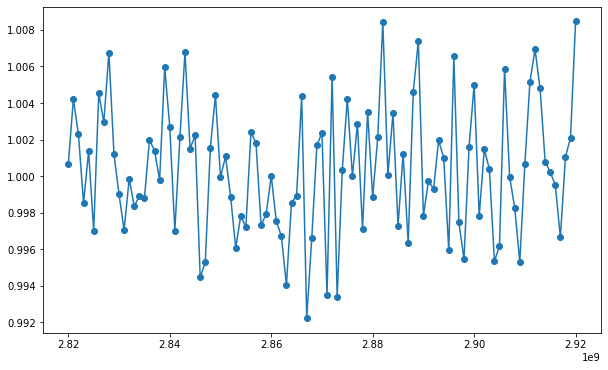

In [22]:


plt.figure(figsize=(10, 6))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

# plt.xlabel('microseconds')
# plt.ylabel('signal/background')
# plt.plot(x_data, rabi_oscillation(x_data, *params),
#          label='Fitted function', color='orange')
# plt.legend()

In [34]:
x_data[y_data<0.980]

array([2.868e+09])

In [27]:
experiment.rf_width = 1.0e-6

print(experiment.experimental_conditions())

full_scans = []

for i in range(50):
    if i % 5 == 0:
        print(i)
    scan_data = experiment.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(i%2==0))
    full_scans.append(scan_data)
    
    #scan_data = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data)

{'freq_low': 2820000000.0, 'freq_high': 2920000000.0, 'freq_step': 1000000.0, 'rf_power': -30, 'rf_width': 1e-06, 'aom_width': 3e-06, 'aom_response_time': 8e-07, 'post_rf_pad': 1e-06, 'pre_rf_pad': 2e-07, 'clock_period': 2e-07}
0
5
10
15
20
25
30
35
40
45


In [28]:
reconstructed_single_scan = recombine_scans(full_scans)

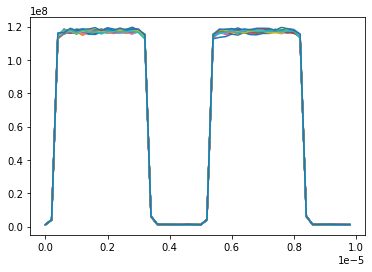

In [29]:
for scan in reconstructed_single_scan[::5]:
    plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

In [30]:
contrast = build_contrast(reconstructed_single_scan, experiment.clock_period, 
                          experiment.aom_width, experiment.rf_width,
                          experiment.post_rf_pad, signal_duty=.5, background_duty=.5)
x_data = contrast[:, 0]
y_data = contrast[:, 1]

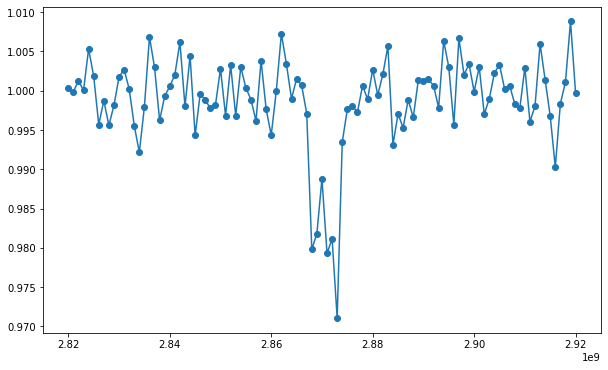

In [31]:
plt.figure(figsize=(10, 6))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

In [32]:
experiment.rf_width = .75e-6

print(experiment.experimental_conditions())

full_scans = []

for i in range(50):
    if i % 5 == 0:
        print(i)
    scan_data = experiment.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(i%2==0))
    full_scans.append(scan_data)
    
    #scan_data = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data)

{'freq_low': 2820000000.0, 'freq_high': 2920000000.0, 'freq_step': 1000000.0, 'rf_power': -30, 'rf_width': 7.5e-07, 'aom_width': 3e-06, 'aom_response_time': 8e-07, 'post_rf_pad': 1e-06, 'pre_rf_pad': 2e-07, 'clock_period': 2e-07}
0
5
10
15
20
25
30
35
40
45


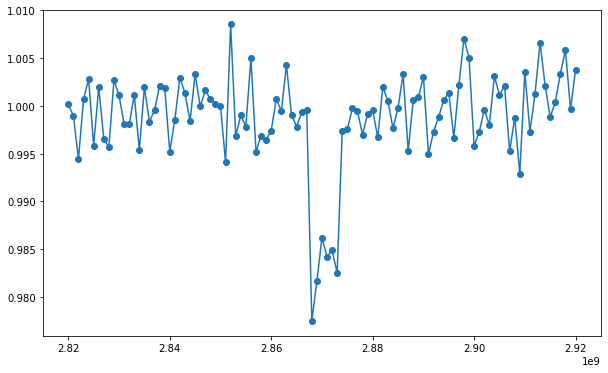

In [33]:
reconstructed_single_scan = recombine_scans(full_scans)
contrast = build_contrast(reconstructed_single_scan, experiment.clock_period, 
                          experiment.aom_width, experiment.rf_width,
                          experiment.post_rf_pad, signal_duty=.5, background_duty=.5)
x_data = contrast[:, 0]
y_data = contrast[:, 1]
plt.figure(figsize=(10, 6))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')